<h1>Neural Networks and Deep Learning Coursework</h1>
<strong>Student:</strong> Mateo Ignacio Ismodes Sole

### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Dataset

In [3]:
# initialize normalizer. code obtained from-> https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # set 0.5 as mean and std for each channel
# )

transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ]
)
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))] 
)


In [4]:
 # import CIFAR10 train and test data
trainDataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
testDataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


## 2. Architecture

In [5]:
# Defining Intermediate Block
class IntermediateBlock(nn.Module):
    def __init__(self, num_input_ch, num_output_ch, num_layers, dropy_c):
        super().__init__()
        self.num_layers = num_layers
        self.fc_layer = nn.Linear(num_input_ch, num_layers)
        self.conv_layers = nn.ModuleList([])
        for i in range(num_layers):
            self.conv_layers.append(nn.Conv2d(num_input_ch, num_output_ch, kernel_size = 3, padding = 'same'))

        self.batchy = nn.BatchNorm2d(num_output_ch)
        self.relu = nn.LeakyReLU()
        self.Pool = nn.MaxPool2d(2)
        self.dropy2d = nn.Dropout2d(dropy_c) # 0.2 -> dropy_c ***********************

    def forward(self, x):
        # Extract channel averages
        ch_avg = torch.mean(x, dim = (2, 3))

        # Use them as input for fully connected layer
        a = self.fc_layer(ch_avg)
        a = self.relu(a) # leaky relu as activation function

        # Store results from convolutional layers
        conv_res = []
        for conv_layer in self.conv_layers:
            conv_res.append(self.relu(conv_layer(x))) # leaky relu as activation function

        # Use coefficients for weighted sum of layers
        conv_res = torch.stack(conv_res)
        a = a.view(self.num_layers, -1, 1, 1, 1)
        x = a * conv_res
        x = torch.sum(x, dim = 0)

        # Additional features
        x = self.batchy(x) # batch normalization
        x = self.Pool(x) # max pooling
        x = self.dropy2d(x) # drop neurons with probability set as coefficient input

        return x

# Defining Output Block
class OutputBlock(nn.Module):
    def __init__(self, num_input_ch, hid_layer_arch: tuple, num_output_ch = 10):
        super().__init__()
        self.hid_layer_arch_length = len(hid_layer_arch)

        if self.hid_layer_arch_length > 0:
            self.fc_hidden_layers = nn.ModuleList([])
            for i in range(self.hid_layer_arch_length):
                if i == 0:
                    self.fc_hidden_layers.append(nn.Linear(num_input_ch, hid_layer_arch[i]))
                else:
                    self.fc_hidden_layers.append(nn.Linear(hid_layer_arch[i - 1], hid_layer_arch[i]))

            self.fc_final_layer = nn.Linear(hid_layer_arch[-1], num_output_ch)

        else:
            self.fc_final_layer = nn.Linear(num_input_ch, num_output_ch)

        self.relu = nn.LeakyReLU()
        self.dropy = nn.Dropout(0.2) # Fixed Dropout rate of 0.5

    def forward(self, x):
        # Extracting channel averages
        nn_output = torch.mean(x, dim = (2, 3))

        # Channel averages passed to fully connected network as inputs
        if self.hid_layer_arch_length > 0:
            for fc_hidden_layer in self.fc_hidden_layers: # Hidden layers are setup as hyperparameters
                nn_output = fc_hidden_layer(nn_output)
                nn_output = self.relu(nn_output)
                nn_output = self.dropy(nn_output)


        # Output layer
        nn_output = self.fc_final_layer(nn_output)
        return nn_output


# Defining Complete Model
class NNModel(nn.Module):
    def __init__(self, params):
        super().__init__()

        # Append Intermediate Blocks
        self.block_I = nn.ModuleList([])
        for block_i in range(len(params['IntBlockLayerTuple'])):
            num_in_ch = params['IntBlockNumInChTuple'][block_i]
            num_out_ch = params['IntBlockNumOutChTuple'][block_i]
            num_layers = params['IntBlockLayerTuple'][block_i]
            dropy_c = params['IntBlockDropyCoefficients'][block_i]

            self.block_I.append(IntermediateBlock(num_in_ch, num_out_ch, num_layers, dropy_c))

        # Final Fully Connected Network
        self.block_f = OutputBlock(params['OutBlockNumInChInt'], params['OutBlockHiddenLayerArchTuple'])

    def forward(self, x):
        # Input passes through intermediate blocks
        for block in self.block_I:
            x = block(x)

        # Input passes through output block
        x = self.block_f(x)
        return x

    def initialize_weights(self): # Used to improve parameter initialization
        for m in self.modules():
            if (isinstance(m, nn.Conv2d)) or (isinstance(m, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



## 3. Setting up DataLoaders

In [6]:
# Defining batchsize
batch_size = 256

# Creating DataLoaders
trainDataloader = DataLoader(trainDataset, batch_size = batch_size,
                             shuffle=False, num_workers = 12)
testDataloader = DataLoader(testDataset, batch_size = batch_size,
                             shuffle=False, num_workers = 4)


## 4. Training

In [7]:
# Defining Dictionary with Hyperparameters
params = {
    'IntBlockNumInChTuple' : (3, 128, 256),
    'IntBlockNumOutChTuple': (128, 256, 512),
    'IntBlockLayerTuple': (3, 3, 3),
    'OutBlockNumInChInt': 512,
    'OutBlockHiddenLayerArchTuple': (),
    'IntBlockDropyCoefficients': (0.1, 0.2, 0.3)
}

# params = {
#     'IntBlockNumInChTuple' : (3, 64, 128),
#     'IntBlockNumOutChTuple': (64, 128, 512),
#     'IntBlockLayerTuple': (4, 3, 3),
#     'OutBlockNumInChInt': 512,
#     'OutBlockHiddenLayerArchTuple': (),
#     'IntBlockDropyCoefficients': (0.2, 0.3, 0.35)
# }

# Initializing Model
model = NNModel(params).to(device)

# Calculating number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The total number of parameters is: {pytorch_total_params}')

The total number of parameters is: 4444828


In [8]:
# Setting up Training Hyperparameters
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1/(10**8)
num_epochs = 850

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)
softy = nn.Softmax(dim=1)

n_total_steps = len(trainDataloader)

# Setting up lists to store results
batch_loss_list = []
epoch_accuracy_list = []
epoch_accuracy_test_list = []

for epoch in range(num_epochs):

    correct_sum = 0
    labels_sum = 0

    for i, (images, labels) in enumerate(trainDataloader):
        inputs, labels = images.to("cuda"), labels.to("cuda")


        outputs = model(inputs)
        loss = criteria(outputs, labels)

        # Estimating Accuracy without affecting gradients
        with torch.no_grad():
            outputs_conv = softy(outputs)
            _, predicted = torch.max(outputs_conv.data, 1)
            correct_sum += (predicted == labels).sum().item()
            labels_sum += labels.size(0)

        # Deleting previous gradients
        optimizer.zero_grad()

        # Calculating new gradients
        loss.backward()

        # Taking a step with based on found gradients
        optimizer.step()

        batch_loss_list.append(loss.item())

        if (i + 1) % 100 == 0:
            print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1}/{n_total_steps}, loss = {loss.item():.4f}')

    # epoch accuracy
    epoch_accuracy = (correct_sum/labels_sum) * 100
    print(f'epoch {epoch + 1} / {num_epochs}, accuracy = {epoch_accuracy:.4f}')
    epoch_accuracy_list.append(epoch_accuracy)


    # Model Evaluation with Testing Data
    model.eval() # Setting up model for evaluation
    correct = 0
    total = 0

    softy = nn.Softmax(dim=1)

    with torch.no_grad():
        for inputs, labels in testDataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = softy(outputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    print(f'Test Accuracy: {accuracy}%')
    epoch_accuracy_test_list.append(accuracy)
    model.train() # Setting up model for training

    if accuracy >= 91.0:
        break



epoch 1 / 850, step 100/196, loss = 2.3605
epoch 1 / 850, accuracy = 10.2280
Test Accuracy: 11.24%
epoch 2 / 850, step 100/196, loss = 2.3571
epoch 2 / 850, accuracy = 11.4100
Test Accuracy: 15.409999999999998%
epoch 3 / 850, step 100/196, loss = 2.1988
epoch 3 / 850, accuracy = 16.1480
Test Accuracy: 22.29%
epoch 4 / 850, step 100/196, loss = 1.8887
epoch 4 / 850, accuracy = 30.7540
Test Accuracy: 40.08%
epoch 5 / 850, step 100/196, loss = 1.4564
epoch 5 / 850, accuracy = 44.7460
Test Accuracy: 52.12%
epoch 6 / 850, step 100/196, loss = 1.2700
epoch 6 / 850, accuracy = 54.3560
Test Accuracy: 60.75000000000001%
epoch 7 / 850, step 100/196, loss = 1.0703
epoch 7 / 850, accuracy = 60.0500
Test Accuracy: 65.08%
epoch 8 / 850, step 100/196, loss = 0.9390
epoch 8 / 850, accuracy = 65.1500
Test Accuracy: 69.26%
epoch 9 / 850, step 100/196, loss = 0.8752
epoch 9 / 850, accuracy = 68.6760
Test Accuracy: 71.39999999999999%
epoch 10 / 850, step 100/196, loss = 0.8280
epoch 10 / 850, accuracy = 7

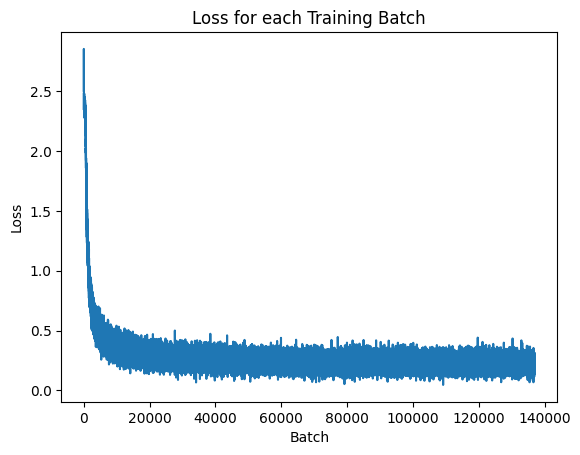

In [9]:
# Loss for each training batch plot
x = np.arange(1, len(batch_loss_list) + 1)
plt.plot(x, batch_loss_list)
plt.title('Loss for each Training Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

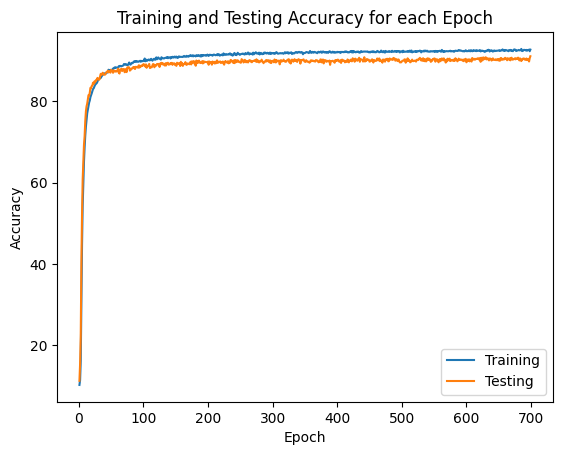

In [10]:
# Training and Testing Accuracy plot
x = np.arange(1, len(epoch_accuracy_list) + 1)
plt.plot(x, epoch_accuracy_list,label = 'Training')
x = np.arange(1, len(epoch_accuracy_test_list) + 1)
plt.plot(x, epoch_accuracy_test_list,label = 'Testing')
plt.title('Training and Testing Accuracy for each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [11]:
# Saving model
torch.save(model.state_dict(), 'finalModel_v2.pt')

## 5. Testing

In [12]:
# Calculating Testing Accuracy after Training
model.eval()
correct = 0
total = 0

softy = nn.Softmax(dim=1)

with torch.no_grad():
    for inputs, labels in testDataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = softy(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy}%')

Test Accuracy: 91.08%
